# About

This notebook builds an IR ranking system. It finetues a CrossEncoder model using a pretrianed BERT model and Train and Evaluation sets. The evaluator used for finetuning is CERerankingEvaluator developed by the sentence transformer package. The ranking system is evaluated by the top 10 ranked passages for each query in the Test set.

reference: https://www.sbert.net/docs/package_reference/cross_encoder.html#evaluation
https://github.com/UKPLab/sentence-transformers/blob/master/examples/training/ms_marco/train_cross-encoder_scratch.py

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
from sentence_transformers import LoggingHandler, util
from datetime import datetime
from sentence_transformers.cross_encoder import CrossEncoder
from torch.utils.data import DataLoader
from sentence_transformers.cross_encoder.evaluation import CERerankingEvaluator, CEBinaryClassificationEvaluator
# import gzip
# import os
# import tarfile
from sentence_transformers import InputExample, losses
from datetime import datetime

In [ ]:
#### Just some code to print debug information to stdout
logging.basicConfig(
    format="%(asctime)s - %(message)s", datefmt="%Y-%m-%d %H:%M:%S", level=logging.INFO, handlers=[LoggingHandler()]
)
#### /print debug information to stdout

# Configure the Training Parameters

In [2]:

train_batch_size = 30
num_epochs = 1
warmup_steps = 5000

# Define functions

In [5]:
def df_to_list(query_df, passage_df):
    """
    # this function create train, test data
    # it reads in query_df and passage_df, then for loop to create a list of list
    # each query, passage pair is a list of 4 elements: [query, passage, score, rel]
    # the ouput is [[query, passage, score, rel], [query, passage, score, rel], ...]
    """
    list_query_passage_score_rel = []
    for index, row in query_df.iterrows():
        list = []
        list.append(row['query'])
        list.append(passage_df[passage_df['passage_id'] == row['passage_id']]["passage"].iloc[0])
        list.append(row["score"])
        list.append(row["rel"])
        list_query_passage_score_rel.append(list)
    return list_query_passage_score_rel

# Read in Train, Validation, Test sets

In [3]:
# query
query_train = pd.read_csv("./output/query_train_set_with_passage_info.csv")
query_val =pd.read_csv("./output/query_val_set_with_passage_info.csv")
query_test =pd.read_csv("./output/query_test_set_with_passage_info.csv")

# passage
passage_train = pd.read_csv("./output/train_passage_id_content_cleaned.csv")
passage_val = pd.read_csv("./output/val_passage_id_content_cleaned.csv")
passage_test = pd.read_csv("./output/test_passage_id_content_cleaned.csv")

In [ ]:
print(query_train.shape)
print(query_val.shape)
print(query_test.shape)

(20000, 9)
(20000, 9)
(20000, 9)


In [ ]:
query_train.head()

,query_id,query,used,passage_id,rank,score,username,rel,query_cleaned
0,568182,what are the characteristics of wool fibres,Q0,msmarco_passage_62_547459701,1,16.102699,Anserini,1,what are the characteristics of wool fibres
1,568182,what are the characteristics of wool fibres,Q0,msmarco_passage_21_588232716,2,14.784700,Anserini,1,what are the characteristics of wool fibres
2,568182,what are the characteristics of wool fibres,Q0,msmarco_passage_11_97323294,3,13.865800,Anserini,1,what are the characteristics of wool fibres
3,568182,what are the characteristics of wool fibres,Q0,msmarco_passage_68_54887603,4,13.865799,Anserini,1,what are the characteristics of wool fibres
4,568182,what are the characteristics of wool fibres,Q0,msmarco_passage_62_547466749,5,13.793600,Anserini,1,what are the characteristics of wool fibres


In [ ]:
passage_train.head()

,passage_id,passage,passage_cleaned,passage_cleaned_lemmatized
0,msmarco_passage_62_547459701,Table of Contents. Growth. Harvesting. Grading...,table of contents growth harvesting grading of...,table content growth harvesting grade wool fib...
1,msmarco_passage_21_588232716,A micron ( micrometre) is the measurement used...,a micron micrometre is the measurement used to...,micron micrometre measurement express diameter...
2,msmarco_passage_11_97323294,Objective measurements include diameter (micro...,objective measurements include diameter micron...,objective measurement include diameter micron ...
3,msmarco_passage_68_54887603,Objective measurements include diameter (micro...,objective measurements include diameter micron...,objective measurement include diameter micron ...
4,msmarco_passage_62_547466749,Summary of Characteristics of Wool Fibers. Woo...,summary of characteristics of wool fibers wool...,summary characteristic wool fiber wool protein...


# Prepare model input for Training

In [ ]:
list_query_passage_score_rel_train = df_to_list(query_train, passage_train)
print(len(list_query_passage_score_rel_train))
list_query_passage_score_rel_train[0:3]

20000


[['what are the characteristics of wool fibres',
  'Table of Contents. Growth. Harvesting. Grading of Wool Fibers. Properties of Wool Fibers. Application of Wool Fibers. Characteristics of Wool Fibers and Products. Summary of Characteristics of Wool Fibers. Of the major apparel fibres, wool is the most reusable and recyclable fibre on the planet.',
  16.102699,
  1],
 ['what are the characteristics of wool fibres',
  'A micron ( micrometre) is the measurement used to express the diameter of wool fibre. Fine wool fibers have a low micron value. Fibre diameter is the most important characteristic of wool in determining its value.',
  14.7847,
  1],
 ['what are the characteristics of wool fibres',
  'Objective measurements include diameter (micron), length, strength, position of break, vegetable matter and colour. AWEX-ID covers subjective characteristics. Diameter. Mean fibre diameter is a measurement in micrometres (microns) of the average diameter of wool fibres in a sale lot. Fibre di

# Prepare model input for Validation

In [ ]:
def produce_evaluation_list(list_qid_eval, query_df, passage_df):

    """
    This function create validation data
    list_qid_eval: a list of query id that contains validation data
    query_df: a pandas df that contains the query text
    passage_df: a pandas df that contains the passage text

    output: a list of dictionaries. 
    each dictionary is for a query and has 3 elements: {"query": query_text, "positive": {positive_passage_text1, positive_passage_text2, ...}
    , "negative": {negative_passage_text1, negative_passage_text2, ...}

    the output look like: [{"query": query_text, "positive": {positive_passage_text1, positive_passage_text2, ...}
    , "negative": {negative_passage_text1, negative_passage_text2, ...}
    , {"query": query_ext, "positive": {positive_passage_text1, positive_passage_text2, ...}
    , "negative": {negative_passage_text1, negative_passage_text2, ...}
    ...]
    """

    list_eval = []

    for qid in list_qid_eval:

        # for each query (qid), create a dictionary
        dev_samples = {}

        # pandas df whose query_id = qid, rows contain all relavent and irrelavent passages
        query_all_passage_subset = query_df[query_df["query_id"] == qid]

        # create the 3 elements for the dictionary
        dev_samples["query"] = query_all_passage_subset["query"].iloc[0]
        dev_samples["positive"] = set()
        dev_samples["negative"] = set()

        # for each qid, for loop each row which may contain relavent or irrelavent passages
        for index, row in query_all_passage_subset.iterrows():
            # if this row contains relavent passage, add the passage text to the value of "positive" key
            if row['rel'] == 1:
                dev_samples["positive"].add(
                    passage_df[passage_df['passage_id'] == row['passage_id']]["passage"].iloc[0])
                
            # if this row contains irrelavent passage, add the passage text to the value of "negative" key
            elif row['rel'] == 0:
                dev_samples["negative"].add(
                    passage_df[passage_df['passage_id'] == row['passage_id']]["passage"].iloc[0])
                
        # append the dictionary for each query to the final output list
        list_eval.append(dev_samples)

    return list_eval

In [ ]:
list_eval = produce_evaluation_list(list_qid_eval = query_val["query_id"].unique()
                        , query_df = query_val
                        , passage_df = passage_val
                        )
print(len(list_eval))
list_eval[0:3]


1000


[{'query': 'what is respiration controlled by',
  'positive': {'2) What organelle is responsible for the process of Photosynthesis and respiration. 3) What raw materials is required for the process of photosynthesis and respiration. 4)What are the main usefull products needed for phtosynthesis and respiration. 5) Is energy given off during photosynthesis or respiration. 6) At what time does the process of photosynthesis and respiration occurs?',
   'Controlling respiration is essential for properly keeping your produce. As long as the respiration process can continue, the fruits and vegetables can be kept well. Since the produce isn’t connected to roots or other parts of the plant anymore, it will not get any new nutrients, it will have to live of what it’s got.',
   'Explain what respirable crystalline silica is and the health hazards associated with it. 3. Know the specific tasks in the workplace that could result in exposure to respirable crystalline silica. 4. Know the types of con

In [ ]:
# random check, ideally, for each of the qid out of the 1000 qid in val, there are ~10 positive passge and ~10 negative passage
for i in [102, 695, 509, 807]:
    print(len(list_eval[i]['positive']), len(list_eval[i]['negative']))

8 9
8 9
8 10
9 7


In [ ]:
evaluator = CERerankingEvaluator(list_eval, name="train-eval")
evaluator


# Load in pretrained model

In [ ]:
# note that sbert provides some pretrained cross encoder model, but some are learned from msmarco dataset: https://huggingface.co/cross-encoder
# here I am using a bert model that is not pertrained using msmarco dataset to avoid the possibility of leaking info to the Test set

model_name = "cross-encoder/stsb-TinyBERT-L-4"#"distilroberta-base"

model_save_path = (
    "output/training_ms-marco_cross-encoder-"
    + model_name.replace("/", "-")
    + "-"
    + datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
)
print(model_save_path)

output/training_ms-marco_cross-encoder-cross-encoder-stsb-TinyBERT-L-4-2024-04-20_13-42-13


In [ ]:
# for parameters, reference https://github.com/UKPLab/sentence-transformers/blob/master/sentence_transformers/cross_encoder/CrossEncoder.py
model = CrossEncoder(model_name
                     , num_labels=1 #outputs a continuous score, for regression or binary classification
                     )
model

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/57.4M [00:00<?, ?B/s]

/home/lingling/project/enter/lib/python3.11/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/517 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

2024-04-20 13:42:17 - Use pytorch device: cpu


# Fine tune the model using Train and Validation sets

In [ ]:
train_sample = []
for list in list_query_passage_score_rel_train:
    train_sample.append(InputExample(texts=[list[0], list[1]], label = list[3]))

train_dataloader = DataLoader(train_sample, shuffle=True, batch_size=train_batch_size)
print(len(train_dataloader))
train_dataloader

In [ ]:

logging.info("Warmup-steps: {}".format(warmup_steps))

# Train the model
model.fit(
    train_dataloader=train_dataloader,
    evaluator=evaluator,
    epochs=num_epochs,
    #If > 0, evaluate the model using evaluator after each number of training steps
    evaluation_steps=10000,
    warmup_steps=warmup_steps,
    output_path=model_save_path,
    use_amp=True,
)


2024-04-20 13:54:30 - Warmup-steps: 5000


/home/lingling/project/enter/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:120: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/667 [00:00<?, ?it/s]

2024-04-20 21:31:02 - CERerankingEvaluator: Evaluating the model on train-eval dataset after epoch 0:
2024-04-20 21:32:14 - Queries: 1000 	 Positives: Min 1.0, Mean 8.9, Max 10.0 	 Negatives: Min 1.0, Mean 8.8, Max 10.0
2024-04-20 21:32:14 - MRR@10: 94.30
2024-04-20 21:32:14 - NDCG@10: 81.86
2024-04-20 21:32:14 - Save model to output/training_ms-marco_cross-encoder-cross-encoder-stsb-TinyBERT-L-4-2024-04-20_13-42-13


# Prepare input for Test Set's Inference

In [ ]:
# # from pandas df to list of list
# list_query_passage_score_rel_test = df_to_list(query_test, passage_test)

# test_sample = []
# for list in list_query_passage_score_rel_test:
#     test_sample.append(InputExample(texts=[list[0], list[1]], label = list[3]))

# print(len(test_sample))
# test_sample[:3]

In [24]:
def create_data_for_inference(query_df, passage_df):
    """
    # this function for loop each query, create list_query_passage (a list of list) for every query: [[query1, passage1], [query1, passage2] ....]
    # then pass this query's list_query_passage to model to make prediction, each query will return a score (list): [score1, score2, score3 ....]
    # the ouput dict_qid_all_prediction is a dictionary that append all query's list_score: {qid1: [score1, score2, score3 ....]}
    # the ouput dict_qid_pid_true is a dictionary that append all query's True ranked qassage {qid1: [pid1, pid2, ..., pid of topn]}
    """

    # create a list of list for all queries [[query1, passage1], [query1, passage2]..., [query2, passage1], [query2, passage2]..., ]
    # This would be used to fit into model to make prediction
    list_query_passage = []


    # create a list of list for all queries [[qid1, pid1], [qid1, pid2]..., [qid2, pid1], [qid2, pid2]..., ]
    # This would be used to collect and sort model prediction
    list_qid_all_pid = []

    # create a dict of dict for all queries {qid1: {pid1: rel, pid2: rel, ...}, qid2: {pid1: rel, pid2: rel, ...}, }
    # This would be used to evaluate model prediction
    dict_of_dict_qid_pid_rel = {}

    # iterate over all qid
    list_qid = query_df["query_id"].unique()
    for qid in list_qid:

        
        # get the rows that contains the qid, pid, score, rel for this qid
        query_df_subset = query_df[query_df['query_id'] == qid]
        
        # iterate over all pid
        for index, row in query_df_subset.iterrows():
            
            # create a list of 2 elements [query, passage]
            list = []
            list.append(row['query'])

            # get the only 1 row that contains the passage text in passage_df and whose pid matches the row's pid
            list.append(passage_df[passage_df['passage_id'] == row['passage_id']]["passage"].iloc[0]) # get passage value

            # append all lists of 2 elements of all queries into one list
            list_query_passage.append(list)

            # append the sublist. Each sublist is the [qid, pid] of the query
            list_qid_all_pid.append([row['query_id'], passage_df[passage_df['passage_id'] == row['passage_id']]['passage_id'].iloc[0]])

        
        
        # for this query, create a dictionary of Y true - each key is a pid, each value is the relavence (1 or 0) of the passage {pid1: 1, pid2, 0, ....}
        dict_pid_rel = pd.Series(query_df_subset['rel'].values, index = query_df_subset['passage_id']).to_dict()

        # append the dict of this query to the dict for all queries 
        dict_of_dict_qid_pid_rel[qid] = dict_pid_rel

    return list_query_passage, list_qid_all_pid, dict_of_dict_qid_pid_rel

In [25]:
list_query_passage, list_qid_all_pid, dict_of_dict_qid_pid_rel = create_data_for_inference(query_test, passage_test)

In [26]:

# check
print(len(list_query_passage))
print(list_query_passage[0])
print(list_query_passage[1000])

print(len(list_qid_all_pid))
print(len(list_qid_all_pid[0]))
print(list_qid_all_pid[0])

print(len(dict_of_dict_qid_pid_rel))
print(len(dict_of_dict_qid_pid_rel[203324]))
print(dict_of_dict_qid_pid_rel[203324])

20000
['him functions to the paper health record', 'This information can be either paper-based, a combination of paper and digital (hybrid) or as is more often the case, a fully electronic health record (EHR). HIM professionals are using advanced technology as they perform most HIM-related functions.']
['what does the word element cyte mean', 'What does -cyte mean? The combining form -cyte is used like a suffix meaning “cell.”. It is often used in medical and scientific terms, especially to name different types of cells. The form -cyte comes from the Greek kýtos, meaning “container,” “receptacle,” “body.”.']
20000
2
[203324, 'msmarco_passage_49_115778700']
1000
20
{'msmarco_passage_49_115778700': 1, 'msmarco_passage_26_450017756': 1, 'msmarco_passage_19_202396335': 1, 'msmarco_passage_28_623516004': 1, 'msmarco_passage_02_47181174': 1, 'msmarco_passage_02_47511835': 1, 'msmarco_passage_11_636220699': 1, 'msmarco_passage_41_133447691': 1, 'msmarco_passage_58_723159152': 1, 'msmarco_pass

# Predict on Test set

In [ ]:
#Load model 
model_save_path = "output/training_ms-marco_cross-encoder-cross-encoder-stsb-TinyBERT-L-4-2024-04-20_13-42-13"
model = CrossEncoder(model_save_path)

In [29]:
# predict 
list_score = model.predict(list_query_passage)


In [66]:
test_with_pred = pd.DataFrame(list_qid_all_pid, columns = ['query_id', 'passage_id'])
test_with_pred['predicted_score'] = list_score
test_with_pred.sort_values(by=['query_id', 'predicted_score'], ascending = False, inplace = True)
test_with_pred.to_csv("./output/test_prediction_TinyBERT-L-4-2024-04-20.csv"
                                       , index = False)
print(test_with_pred.shape)

(20000, 3)


In [49]:
# check
display(test_with_pred[test_with_pred["query_id"] == 1183224])

,query_id,passage_id,predicted_score
10360,1183224,msmarco_passage_64_307501210,0.902275
10372,1183224,msmarco_passage_03_2856732,0.737706
10361,1183224,msmarco_passage_01_536296949,0.688284
10362,1183224,msmarco_passage_06_770443306,0.688284
10366,1183224,msmarco_passage_48_764103270,0.688284
10367,1183224,msmarco_passage_48_800555103,0.688284
10378,1183224,msmarco_passage_37_349325721,0.670941
10368,1183224,msmarco_passage_27_266644928,0.640532
10371,1183224,msmarco_passage_01_493126868,0.614931
10369,1183224,msmarco_passage_48_449276269,0.610131


# Plot distribution of predicted score

(array([216., 194., 202., 186., 176., 192., 197., 234., 245., 227., 275.,
        291., 285., 340., 333., 336., 361., 422., 446., 469., 481., 587.,
        602., 606., 628., 700., 659., 668., 801., 711., 791., 786., 836.,
        820., 747., 666., 687., 586., 599., 435., 337., 253., 156.,  88.,
         45.,  58.,  26.,  11.,   2.,   1.]),
 array([0.02170377, 0.0405684 , 0.05943304, 0.07829767, 0.09716231,
        0.11602694, 0.13489157, 0.15375622, 0.17262085, 0.19148548,
        0.21035011, 0.22921474, 0.24807937, 0.26694402, 0.28580865,
        0.30467328, 0.32353792, 0.34240255, 0.36126718, 0.38013181,
        0.39899644, 0.41786107, 0.43672574, 0.45559037, 0.474455  ,
        0.49331963, 0.51218426, 0.53104889, 0.54991353, 0.56877816,
        0.58764279, 0.60650742, 0.62537205, 0.64423668, 0.66310132,
        0.68196595, 0.70083058, 0.71969521, 0.73855984, 0.75742453,
        0.77628917, 0.7951538 , 0.81401843, 0.83288306, 0.85174769,
        0.87061232, 0.88947695, 0.90834159, 0.

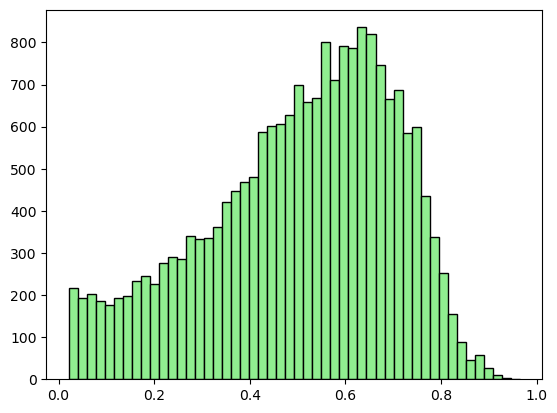

In [64]:
plt.hist(test_with_pred["predicted_score"], color='lightgreen', ec='black', bins=50)

# Evaluate using MRR@10

In [50]:
dict_qid_all_pid_prediction = {}

for qid, group in test_with_pred.groupby('query_id'):
    dict_qid_all_pid_prediction[qid] = group['passage_id'].values.tolist()

In [51]:

topn = 10
mrr = 0.0
qids = []
rrs = []

# iterate over all the qid (keys in the dictionary)
for qid in dict_qid_all_pid_prediction:

    rr = 0.0
    
    # iterate over all the element of topn pid [pid1, pid2, ... pid topn]
    for i, pid in enumerate(dict_qid_all_pid_prediction[qid][: topn + 1]):

        # check if the pid has relenvace > 0
        if qid in dict_of_dict_qid_pid_rel and pid in dict_of_dict_qid_pid_rel[qid] and dict_of_dict_qid_pid_rel[qid][pid] > 0:
        
            rr = 1 / (i+1)
        
            break
    qids.append(qid)
    rrs.append(rr)
    mrr += rr
mrr /= len(dict_qid_all_pid_prediction)
print("MRR@10: ", mrr)

MRR@10:  0.946619047619048


# Evaluate using MAP@10

In [65]:
print(query_test.shape)
print(test_with_pred.shape)

result = query_test.merge(test_with_pred, how = "inner", on = ["query_id", "passage_id"])
print(result.shape)
display(result.head())

(20000, 9)
(20000, 3)
(20000, 10)


,query_id,query,used,passage_id,rank,score,username,rel,query_cleaned,predicted_score
0,203324,him functions to the paper health record,Q0,msmarco_passage_49_115778700,1,13.2671,Anserini,1,him functions to the paper health record,0.572222
1,203324,him functions to the paper health record,Q0,msmarco_passage_26_450017756,2,11.8537,Anserini,1,him functions to the paper health record,0.512837
2,203324,him functions to the paper health record,Q0,msmarco_passage_19_202396335,3,11.2738,Anserini,1,him functions to the paper health record,0.457086
3,203324,him functions to the paper health record,Q0,msmarco_passage_28_623516004,4,11.0361,Anserini,1,him functions to the paper health record,0.592055
4,203324,him functions to the paper health record,Q0,msmarco_passage_02_47181174,5,10.9476,Anserini,1,him functions to the paper health record,0.542745


In [59]:
# Function for calculating average precision for a query
def average_precision(qid, topn = 10):
    
    # ========= for each query_id, do the following:
    #print(f"Started to work on query_id {qid}")
    # get passage_id (each query_id would have upto 10 passage_id)
    qresult = result.loc[result["query_id"] == qid, ["passage_id", "rel", "predicted_score"]]


    
    # sort rows so that passages with the highest similarity ranks as top 
    qresult.sort_values(by="predicted_score", ascending = False, inplace=True)

    # # Taking Top 10 documents for the evaluation
    ranking = qresult.head(topn)['rel'].values
    #display(qresult.head(topn))
    
    # # Calculating precision
    precision=[]
    for i in range(1,11):
      if ranking[i-1]:
        precision.append(np.sum(ranking[:i])/i)
    
    # If no relevant document in list then return 0
    if precision==[]:
      return 0
    #print(len(precision))
    #print(precision)
    avg_precision = np.mean(precision)
    #print("Avg precision: {}".format(avg_precision))
    return avg_precision#, len(precision), qresult.shape[0]

In [60]:
result["avg_precision"] = result.apply(lambda x: average_precision(x['query_id'])
                                    ,axis=1)

In [61]:
result.head()

,query_id,query,used,passage_id,rank,score,username,rel,query_cleaned,predicted_score,avg_precision
0,203324,him functions to the paper health record,Q0,msmarco_passage_49_115778700,1,13.2671,Anserini,1,him functions to the paper health record,0.572222,0.873413
1,203324,him functions to the paper health record,Q0,msmarco_passage_26_450017756,2,11.8537,Anserini,1,him functions to the paper health record,0.512837,0.873413
2,203324,him functions to the paper health record,Q0,msmarco_passage_19_202396335,3,11.2738,Anserini,1,him functions to the paper health record,0.457086,0.873413
3,203324,him functions to the paper health record,Q0,msmarco_passage_28_623516004,4,11.0361,Anserini,1,him functions to the paper health record,0.592055,0.873413
4,203324,him functions to the paper health record,Q0,msmarco_passage_02_47181174,5,10.9476,Anserini,1,him functions to the paper health record,0.542745,0.873413


In [62]:
print('Mean Average Precision=>', result["avg_precision"].mean())

Mean Average Precision=> 0.8848143230347694


In [63]:
result.to_csv("./output/test_prediction_avg_precision_TinyBERT-L-4-2024-04-20.csv"
                                       , index = False)
